# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ovm.monetary.model import MonetaryModel

import logging
import os
import random
import typing as tp

import line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget
from mesa.datacollection import DataCollector
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from tqdm import tqdm

from ovm.monetary.agents import (
    MonetaryAgent, 
    MonetaryArbitrageur, 
    MonetaryKeeper
)

from ovm.monetary.markets import MonetaryFMarket
from ovm.monetary.model import MonetaryModel
from ovm.monetary.options import DataCollectionOptions
from ovm.monetary.plot_labels import (
    price_deviation_label,
    spot_price_label,
    futures_price_label,
    skew_label,
    inventory_wealth_ovl_label,
    inventory_wealth_usd_label,
    GINI_LABEL,
    GINI_ARBITRAGEURS_LABEL,
    SUPPLY_LABEL,
    TREASURY_LABEL,
    LIQUIDITY_LABEL, 
)

from ovm.monetary.plots import (
    DEFAULT_FIGURE_SIZE, 
    convert_time_interval_in_seconds_to_indices, 
    construct_full_time_axis, 
    construct_time_axis, 
    get_indices_and_time_axis_to_plot, 
    plot_multiple_variables_over_time, 
    plot_price_deviations, 
    plot_skews, 
    plot_single_variable_over_time, 
    plot_supply, 
    plot_treasury, 
    plot_liquidity, 
    plot_spot_vs_futures_price
)

from ovm.monetary.reporters import * 
from ovm.monetary.data_io import (
    construct_sims_map, 
    construct_ticker_to_series_of_prices_map_from_simulated_prices
)

from ovm.paths import (
    HistoricalDataSource, 
    construct_historical_data_directory
)

from ovm.simulation.bootstrap import plot_multivariate_simulation
from ovm.simulation.resampling import (
    load_log_returns,
    simulate_new_price_series_via_bootstrap,
    store_simulated_price_series_in_output_directory
)

from ovm.tickers import (
    ETH_USD_TICKER,
    COMP_USD_TICKER,
    LINK_USD_TICKER,
    YFI_USD_TICKER
)

from ovm.time_resolution import (
    TimeResolution, 
    TimeScale
)

In [3]:
logger = logging.getLogger(__name__)
logger.level

0

In [4]:
logging.getLevelName(logging.root.level)

'WARNING'

In [5]:
logging.root.level

30

In [6]:
%load_ext line_profiler

# Set Parameters

In [7]:
time_resolution = TimeResolution.FIFTEEN_SECONDS

# 200000 steps corresponds to about 1.14 months
# 200000 * 15 / 60 / 60 / 24 / 365.25 * 12 = 1.14077116131
# number_of_steps_to_simulate = 200000

# number_of_steps_to_simulate = 1000

# 700000 steps corresponds to about 4 months (i.e. 1/3 year with 15 seconds per step)
# 700000 * 15 / 60 / 60 / 24 / 365.25 = 0.33272492204
# number_of_steps_to_simulate = 700000

# number_of_steps_to_simulate = int(24 * 60 * 60 / time_resolution.in_seconds)

# run agent based simulations for 2 years
number_of_steps_to_simulate = int(2 * 365.25 * 24 * 60 * 60 / time_resolution.in_seconds)
print(f'number_of_steps_to_simulate={number_of_steps_to_simulate}')

directory_path = \
    construct_historical_data_directory(
        historical_data_source=HistoricalDataSource.FTX, 
        time_resolution=time_resolution)
numpy_seed = 42

tickers = [ETH_USD_TICKER,
           # not a long history of simulation (can we use a different token instead)
           COMP_USD_TICKER,
           # not a long history of simulation (can we use a different token instead)
           LINK_USD_TICKER,
           # less than half a year of simulation (can we use a different token instead)
           YFI_USD_TICKER
           ]

ovl_usd_replacement_ticker = 'YFI-USD'
ovl_usd_ticker = 'OVL-USD'

tickers_with_ovl = [ovl_usd_ticker if ticker == ovl_usd_replacement_ticker else ticker for ticker in tickers]
tickers_with_ovl

number_of_steps_to_simulate=4207680


['ETH-USD', 'COMP-USD', 'LINK-USD', 'OVL-USD']

# Load Historical Price Data and Resample

In [8]:
log_return_df, closing_price_df, initial_prices = \
    load_log_returns(series_names=tickers,
                     period_length_in_seconds=time_resolution.in_seconds,
                     directory_path=directory_path)
log_return_df.shape

(705007, 4)

In [9]:
simulated_sample_length_in_seconds = \
    5 * 365.25 * 24 * 60 * 60

# simulated_sample_length_in_seconds = log_return_df.shape[0] * time_resolution.in_seconds
np.random.seed(numpy_seed)

simulated_prices = \
    simulate_new_price_series_via_bootstrap(
        initial_prices=initial_prices,
        input_log_return_df=log_return_df,
        time_resolution=time_resolution,
        block_length_in_seconds=4 * 24 * 60 * 60,  # 4 day block length
        simulated_sample_length_in_steps_in_seconds=simulated_sample_length_in_seconds,
            number_of_paths=1)
simulated_prices.shape

(1, 10519200, 4)

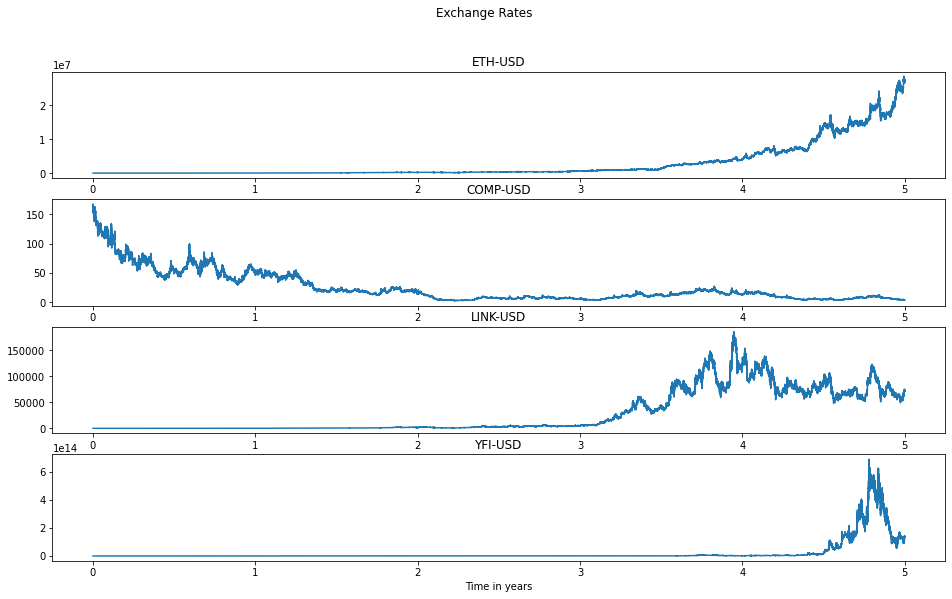

In [10]:
plot_multivariate_simulation(simulated_data=simulated_prices,
                             series_names=tickers, 
                             time_resolution=time_resolution, 
                             title='Exchange Rates')

In [11]:
ticker_to_time_series_of_prices_map = \
    construct_ticker_to_series_of_prices_map_from_simulated_prices(simulated_prices=simulated_prices, 
                                                                   tickers=tickers_with_ovl)

# Load Resampled Data

# Construct Agent Based Monetary Model

In [12]:
# """
# Configure visualization elements and instantiate a server
# """


# def random_color():
#     return '#%02X%02X%02X' % (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))



# Constants
STEPS_MONTH = int((86400*30) / time_resolution.in_seconds)

total_supply = 100000  # OVL
base_wealth = 0.0001*100000  # OVL
# base_wealth = 0.0005*100000  # OVL
base_market_fee = 0.0030
base_max_leverage = 10.0
time_liquidity_mine = STEPS_MONTH

# For the first 30 days, emit until reach 100% of total supply; ONLY USE IN LIQUDITIY FOR NOW JUST AS TEST!
liquidity_supply_emission = [(0.51*total_supply/time_liquidity_mine)*i + 0.285*total_supply
                             for i
                             in range(time_liquidity_mine)]

num_arbitrageurs = \
    min(max(len(ticker_to_time_series_of_prices_map.keys()) * 5, 
            int(total_supply*0.01/base_wealth)), 
        100)
num_keepers = max(len(ticker_to_time_series_of_prices_map.keys()), int(total_supply * 0.005 / base_wealth))
# num_traders = min(int(total_supply*0.2/base_wealth), 100)
num_traders = 0
# num_holders = min(int(total_supply*0.5/base_wealth), 100)
num_holders = 0
num_agents = num_arbitrageurs + num_keepers + num_traders + num_holders

liquidity = 0.285*total_supply
treasury = 0.0
sampling_interval = 240

# TODO: Vary these initial num_ ... numbers; for init, reference empirical #s already seeing for diff projects
model_kwargs = {
    "ticker_to_time_series_of_prices_map": ticker_to_time_series_of_prices_map,
    "num_arbitrageurs": num_arbitrageurs,
    "num_keepers": num_keepers,
    "num_traders": num_traders,
    "num_holders": num_holders,
    "base_wealth": base_wealth,
    "base_market_fee": base_market_fee,
    "base_max_leverage": base_max_leverage,
    # Setting liquidity = 100x agent-owned OVL for now; TODO: eventually have this be a function/array
    "liquidity": liquidity,
    "liquidity_supply_emission": liquidity_supply_emission,
    "treasury": treasury,
    # TODO: 1920 ... 8h with 15s blocks (sim simulation is every 15s)
    "sampling_interval": sampling_interval,
}

print("Model kwargs for initial conditions of sim:")
print(f"num_arbitrageurs = {model_kwargs['num_arbitrageurs']}")
print(f"num_keepers = {model_kwargs['num_keepers']}")
print(f"num_traders = {model_kwargs['num_traders']}")
print(f"num_holders = {model_kwargs['num_holders']}")
print(f"total number of agents = {num_agents}")
print(f"base_wealth = {model_kwargs['base_wealth']}")


data_collection_options = \
    DataCollectionOptions(perform_data_collection=True, 
                          compute_gini_coefficient=False,
                          compute_wealth=False,
                          compute_inventory_wealth=False, 
                          data_collection_interval=4  # collect data once per minute (every 4 steps)
                         )

base_liquidate_reward = 0.1
base_maintenance = 0.6
num_snipers = 0
num_liquidators = 0

monetary_model = \
    MonetaryModel(num_arbitrageurs=num_arbitrageurs, 
                  num_keepers=num_keepers, 
                  num_traders=num_traders, 
                  num_holders=num_holders, 
                  num_snipers=num_snipers, 
                  num_liquidators=num_liquidators, 
                  base_maintenance=base_maintenance, 
                  base_liquidate_reward=base_liquidate_reward, 
                  sims=ticker_to_time_series_of_prices_map, 
                  base_wealth=base_wealth, 
                  base_market_fee=base_market_fee, 
                  base_max_leverage=base_max_leverage, 
                  liquidity=liquidity, 
                  liquidity_supply_emission=liquidity_supply_emission, 
                  treasury=treasury, 
                  sampling_interval=sampling_interval, 
                  data_collection_options=data_collection_options)

Model kwargs for initial conditions of sim:
num_arbitrageurs = 100
num_keepers = 50
num_traders = 0
num_holders = 0
total number of agents = 150
base_wealth = 10.0


Drastically reduced the number of traders and holders to bring down the memory requirement for storing agent wealth (with the original numbers it would have been 7500 agents total). This would exceed the 128GB mem of my machine with 200000 steps

# Run Simulation

In [13]:
def run_model(number_of_steps_to_simulate: int):
    for i in tqdm(range(number_of_steps_to_simulate + 1)):
        monetary_model.step()

In [14]:
number_of_steps_to_simulate

4207680

In [ ]:
run_model(number_of_steps_to_simulate)

 38%|███▊      | 1609699/4207681 [09:05<25:23, 1705.74it/s]

In [ ]:
# %lprun \
#     -f compute_gini \
#     -f compute_price_difference \
#     -f compute_futures_price \
#     -f compute_spot_price \
#     -f compute_supply \
#     -f compute_liquidity \
#     -f compute_treasury \
#     -f compute_wealth_for_agent_type \
#     -f compute_inventory_wealth_for_agent \
#     -f compute_inventory_wealth_for_agent_type \
#     -f compute_positional_imbalance_by_market \
#     -f DataCollector.collect \
#     -f MonetaryAgent.step \
#     -f MonetaryArbitrageur._unwind_positions \
#     -f MonetaryArbitrageur._unwind_next_position \
#     -f MonetaryArbitrageur.trade \
#     -f MonetaryArbitrageur.step \
#     -f MonetaryKeeper.step \
#     -f MonetaryKeeper.distribute_funding \
#     -f MonetaryFMarket.build \
#     -f MonetaryFMarket.unwind \
#     -f MonetaryFMarket._swap \
#     -f MonetaryFMarket.slippage \
#     -f MonetaryFMarket.fund \
#     -f MonetaryFMarket.funding \
#     -f MonetaryFMarket.liquidatable \
#     -f MonetaryFMarket.liquidate \
#     -f MonetaryModel.step \
#     run_model(number_of_steps_to_simulate)

# Extract Model Variables

In [ ]:
model_vars_df = monetary_model.data_collector.get_model_vars_dataframe()
model_vars_df.head()

In [ ]:
model_vars_df.memory_usage(deep=True)

In [ ]:
model_vars_df.info()

In [ ]:
# fig = px.line(model_vars_df, y="Supply", title='OVL Supply')
# fig = px.line(model_vars_df, y="Treasury", title='Treasury')
# fig.show()

# Extract Agent Variables

In [ ]:
agent_vars_df = monetary_model.data_collector.get_agent_vars_dataframe()
print(len(agent_vars_df))

In [ ]:
agent_vars_df.info()

In [ ]:
agent_vars_df.tail(300)

In [ ]:
# agent_vars_df.loc[(699999, 1), :]
# df.loc[('cobra', 'mark i'), 'shield']

In [ ]:
def convert_time_in_seconds_to_index(
    time_resolution: TimeResolution, 
    time_in_seconds: float):
    return int(np.floor(time_in_seconds / time_resolution.in_seconds))

In [ ]:
one_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 * 24 * 60 * 60)
one_year_index

In [ ]:
one_day_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=24 * 60 * 60)
one_day_index

In [ ]:
# agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_year_index, :], :].values
agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values

In [ ]:
agent_wealth.shape

In [ ]:
agent_wealth.sum()

In [ ]:
sorted(agent_wealth[:100])

In [ ]:
histogram = plt.hist(agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values)

In [ ]:
sns.kdeplot(data=agent_wealth);

# Plot Results

## New Plots with 100 Arbitrageurs (no traders and no holders)

In [ ]:
plot_time_scale = TimeScale.YEARS

### Set Plot Horizon in Seconds

In [ ]:
plot_begin_years = 0.0
# plot_end_years = 5 * 365.25 * 24 * 60 * 60  # 5 years
# plot_end_years = 0.75 * 365.25 * 24 * 60 * 60  # 9 months
plot_end_years = 1 * 365.25 * 24 * 60 * 60  # 1 year
time_interval_to_plot_in_seconds = (plot_begin_years, plot_end_years)
time_interval_to_plot_in_seconds = None

### OVL Supply

In [ ]:
plot_supply(model_vars_df=model_vars_df, 
            plot_time_scale=plot_time_scale, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
            time_resolution=time_resolution, 
            data_interval=4)

### Liquidity

In [ ]:
# plot_liquidity(model_vars_df=model_vars_df,  
#                plot_time_scale=plot_time_scale, 
#                time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
#                time_resolution=time_resolution, 
#                data_interval=4)

### Treasury

In [ ]:
plot_treasury(model_vars_df=model_vars_df, 
              plot_time_scale=plot_time_scale, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
              time_resolution=time_resolution, 
              data_interval=4) 

### Price Deviations

In [ ]:
plot_price_deviations(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Skew

In [ ]:
plot_skews(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

#### Correlation between Skew and Futures Price

In [ ]:
for i, ticker in enumerate(tickers_with_ovl):
    if i > 0:
        break
    skew = model_vars_df.loc[:, skew_label(ticker)].values
    futures_price = model_vars_df.loc[:, futures_price_label(ticker)].values
    spot_price = model_vars_df.loc[:, spot_price_label(ticker)].values
    print(np.corrcoef(skew, futures_price))
    print(np.corrcoef(skew, spot_price))

### Spot vs. Futures Prices

In [ ]:
for i, ticker in enumerate(tickers_with_ovl):
    plot_spot_vs_futures_price(
        model_vars_df=model_vars_df, 
        ticker=ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)

In [ ]:
plt.close('all')